# Détection de Fraudes Bancaires

La fraude bancaire représente un enjeu majeur pour les institutions financières.
L’objectif de ce projet est de concevoir un modèle de Machine Learning capable de détecter automatiquement les transactions frauduleuses, tout en minimisant les fraudes non détectées.

Ce notebook présente le projet complet de détection de fraudes bancaires.

Objectifs :
- Détecter automatiquement les transactions frauduleuses
- Industrialiser le modèle via FastAPI et MLOps



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Chargement et inspection rapide des Données

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_name = "/content/drive/MyDrive/Colab Notebooks/creditcard.csv"

In [4]:
file_name = "/content/drive/MyDrive/Colab Notebooks/creditcard.csv"
df = pd.read_csv(file_name)
print("Apercu des 5 premieres lignes")
print(df.head())
print("\n Informations sur le DataFrame (types de donnees et valeurs manquantes)")
df.info()

Apercu des 5 premieres lignes
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

  

## Analyse du déséquilibre des classes

Le dataset est très déséquilibré (~0.17% de fraudes)


In [5]:
TARGET_COL = 'Class'
class_counts = df[TARGET_COL].value_counts()
total_transactions = len(df)
class_percentages = class_counts / total_transactions * 100
print("\n Repartition des classes (Desequilibre)")
print(class_counts)
print(f"\npourcentages des classes : \n{class_percentages.round(2)}%")


 Repartition des classes (Desequilibre)
Class
0    284315
1       492
Name: count, dtype: int64

pourcentages des classes : 
Class
0    99.83
1     0.17
Name: count, dtype: float64%


Visualisation du Déséquilibre

/tmp/ipython-input-1649561734.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=['skyblue', 'salmon'])


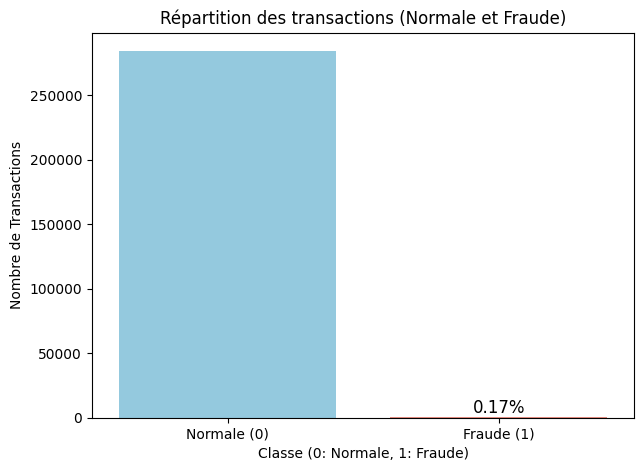

In [7]:
plt.figure(figsize=(7, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['skyblue', 'salmon'])
for i, count in enumerate(class_counts.values):
    percentage = class_percentages.iloc[i].round(2)
plt.text(i, count, f'{percentage}%', ha='center', va='bottom', fontsize=12)
plt.title('Répartition des transactions (Normale et Fraude)')
plt.xlabel('Classe (0: Normale, 1: Fraude)')
plt.ylabel('Nombre de Transactions')
plt.xticks(class_counts.index, ['Normale (0)', 'Fraude (1)'])
plt.show()

## Prétraitement et rééchantillonnage (SMOTE)

- Séparation des features et de la cible
- Split train/test
- Application de SMOTE sur l'ensemble d'entraînement

(on utilise SMOTE car etant donné que nous n'avons que 0.17% de fraudes, l'Undersampling est risqué car il réduirait drastiquement la taille de notre dataset. Le Sur-échantillonnage (en particulier SMOTE) est souvent préféré pour conserver un maximum d'informations.

In [8]:
!pip install imbalanced-learn

In [10]:
from sklearn.model_selection import train_test_split
TARGET_COL = 'Class'
X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]

#pour gerer les variables
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Application de SMOTE sur le jeu d'entrainement

In [11]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("\n Repartition des classes apres SMOTE")
print(y_train_resampled.value_counts())


 Repartition des classes apres SMOTE
Class
0    199020
1    199020
Name: count, dtype: int64


## Entraînement et comparaison des modèles

- Random Forest
- XGBoost

Métrique prioritaire : Recall pour la classe fraude


In [12]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time

In [13]:
print("Entrainement du modele Random Forest")
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42,
                                          class_weight='balanced_subsample',
                                          n_jobs=-1))
])

# Entrainement
start_time = time.time()
rf_pipeline.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
print(f"Temps d'entrainement : {end_time - start_time:2f}secondes.")

Entrainement du modele Random Forest
Temps d'entrainement : 464.165908secondes.


In [14]:
print("\n Entrainement du modele XGBoost")
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        n_estimators=100,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    ))
])

# Entrainement
start_time = time.time()
xgb_pipeline.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
print(f"Temps d'entrainement : {end_time - start_time:2f}secondes.")


 Entrainement du modele XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:03:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Temps d'entrainement : 9.512295secondes.


In [19]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n Resultats pour {model_name}")
    print("\n Classification Report (seuil 0.5)")
    report = classification_report(y_test, y_pred, target_names=['Normal (0)', 'Fraude (1)'], output_dict=True)
    print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Fraude (1)']))
    cm = confusion_matrix(y_test, y_pred)
    print("\n Matrice de Confusion")
    print(cm)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nAUC-ROC Score : {roc_auc:.4f}")
    false_negatives = cm[1,0]
    total_frauds = cm[1,0] + cm[1,1]
    print(f"\nFaux Negatifs (Fraudes Manquees) : {false_negatives} sur {total_frauds} fraudes totales.")

    recall_score = report['Fraude (1)']['recall']
    return roc_auc, recall_score

## Évaluation des modèles

Comparaison des performances Random Forest vs XGBoost :
- Recall (fraude)
- AUC-ROC


In [16]:
from sklearn.metrics import classification_report, roc_auc_score

# Random Forest
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]
rf_report = classification_report(y_test, rf_pipeline.predict(X_test), target_names=['Normal (0)', 'Fraude (1)'], output_dict=True)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)
rf_recall_fraud = rf_report['Fraude (1)']['recall']

# XGBoost
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
xgb_report = classification_report(y_test, xgb_pipeline.predict(X_test), target_names=['Normal (0)', 'Fraude (1)'], output_dict=True)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)
xgb_recall_fraud = xgb_report['Fraude (1)']['recall']

# Affichage des résultats pour une comparaison
print(f"{'Modèle':<20} | {'Recall (Fraude)':<18} | {'AUC-ROC Score':<15}")
print("-" * 55)
print(f"{'Random Forest':<20} | {rf_recall_fraud:<18.4f} | {rf_auc:<15.4f}")
print(f"{'XGBoost':<20} | {xgb_recall_fraud:<18.4f} | {xgb_auc:<15.4f}")

Modèle               | Recall (Fraude)    | AUC-ROC Score  
-------------------------------------------------------
Random Forest        | 0.7905             | 0.9494         
XGBoost              | 0.7973             | 0.9779         


## Sauvegarde du modèle et des colonnes

- Le modèle XGBoost est retenu pour sa meilleure performance
- Sauvegarde pour déploiement et API


In [ ]:
import joblib
import pickle
from google.colab import files

# 1. Pour Sauvegarder le modèle entraîné
joblib.dump(xgb_pipeline, 'xgb_fraud_detector.joblib')

# 2. Pour Sauvegarder la liste des colonnes
feature_cols = list(X_train_resampled.columns)
with open('features.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print("Sauvegarde terminée. Téléchargement en cours...")

# 3. Pour Télécharger les fichiers
files.download('xgb_fraud_detector.joblib')
files.download('features.pkl')

Sauvegarde terminée. Téléchargement en cours...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Déploiement via API et MLOps

Le modèle XGBoost entraîné est déployé via une API FastAPI pour la détection de fraude en temps réel.

### Points clés :
- Validation des entrées avec Pydantic
- Sélection stricte des features
- Prédiction rapide avec mesure du temps de réponse
- Logging centralisé dans `api_predictions.log`
- Endpoint `/health` pour vérifier le modèle

Cette configuration MLOps garantit :
1. Traçabilité des prédictions
2. Reproductibilité du modèle
3. Base solide pour monitoring futur


## Conclusion

Ce projet présente un pipeline complet de détection de fraude :
- Analyse et prétraitement
- Modélisation et sélection du meilleur modèle
- Déploiement via API FastAPI
- Logging et MLOps pour la traçabilité

Ce notebook représente le **rapport méthodologique complet** du projet.
